# Wave Combinator Session Data Exploration

This template is designed to help you explore per-session data from the Wave Combinator game.
It presents statistics and visualizations to help you understand characteristics of data for the given file,
and makes it easy to tweak the code to further explore your data.

# Environment Setup and Import

In [1]:
import os
print(os.getcwd())
!pip install --quiet --no-input -r ../../requirements.txt --log ./pip-installations.log

c:\Users\subsc\Documents\_work\FieldDay\OpenGameData\opengamedata-samples\WAVES\explore


In [2]:
# Standard Libraries
import math
import shutil
import urllib.request as urlrequest
from collections import Counter
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Change pandas `max_rows` and `max_columns`

 *Note: There may be other variables to manually change. Look the "Set Variables" section.*

In [3]:
pd.options.display.max_columns = 4000 #@param {type:"integer"}
pd.options.display.max_rows = 60 #@param {type:"integer"}

## Retrieve Data Files

#### Please change `OGD_SERVER` and `zip_name` if you want to get a file from a different location.
#### The cells below will error if `OGD_SERVER` and `zip_name` are invalid.

In [4]:
# Configure Server Info

OGD_SERVER = 'http://opengamedata.fielddaylab.wisc.edu/'
SERVER_DATA_PATH = 'data/WAVES/'

dataset_name = "WAVES_20230201_to_20230228"
zip_name = f"{dataset_name}_5de1a1f_events_sample.zip"

In [5]:
# Download the file if it doesn't exist.
if not Path(f'./{zip_name}').is_file():
    print(f"Didn't find the file {zip_name} locally, downloading from {OGD_SERVER}...")
    file_url = f"{OGD_SERVER}{SERVER_DATA_PATH}{zip_name}"
    !curl --ssl-no-revoke {file_url} -o {zipname}
    # with urlrequest.urlopen(ogd_server + zipname, verify=False) as remote_file, open(zipname, 'wb') as local_file:
    #     shutil.copyfileobj(remote_file, local_file)
    #     print(f"Successfully downloaded a copy of the file.")

### Import Data Files to Jupyter

In [6]:
# Open TSV from the zip file.

zip_file = ZipFile(Path(f'./{zip_name}'))
tsv_name = f"{dataset_name}_5de1a1f_events_sample.tsv"
raw_data = pd.DataFrame()
with zip_file.open(f"{dataset_name}/{tsv_name}") as tsv_file:
    raw_data = pd.read_csv(tsv_file, sep='\t')
data_readme = zip_file.read(f"{dataset_name}/readme.md")
zip_file.close()

# Data Overview

### Dataset README

Below, the readme file included with your dataset is displayed.
It includes information on the events and features for Wave Combinator.

In [7]:
display(Markdown(data_readme.decode()))

## Data Logging Info:
See https://github.com/fielddaylab/waves/blob/master/README.md

Wave data is organized into levels, where each level is a distinct puzzle in the game.



### Data "Shape"

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    10000 non-null  int64  
 1   session_id    10000 non-null  int64  
 2   app_id        10000 non-null  object 
 3   timestamp     10000 non-null  object 
 4   event_name    10000 non-null  object 
 5   event_data    10000 non-null  object 
 6   event_source  10000 non-null  object 
 7   app_version   10000 non-null  int64  
 8   app_branch    10000 non-null  object 
 9   log_version   10000 non-null  int64  
 10  offset        10000 non-null  object 
 11  user_id       0 non-null      float64
 12  user_data     10000 non-null  object 
 13  game_state    10000 non-null  object 
 14  index         10000 non-null  int64  
dtypes: float64(1), int64(5), object(9)
memory usage: 1.1+ MB


In [9]:
print(f"This dataset has {raw_data.shape[0]} Rows, {raw_data.shape[1]} Columns")

This dataset has 10000 Rows, 15 Columns


### Column Names

Each OpenGameData events file contains a standard set of columns.
These include columns identifying the player (User ID, Session ID, User Data), the time (Timestamp), the state of the game (Game State), and the event itself (Event Name, Event Data).
The Event Data represents what is unique to each individual type of event, while other columns represent data common across all events (time, player, etc.)  
Note that not all games use every column.
In particular, Wave Combinator does not distinguish individual players, only individual gameplay sessions.

Below, the column names are listed.
We also list out the names of each event type found in the datafile.

In [10]:
id_columns = pd.Index(["session_id", "user_id"])

In [11]:
pprint(list(raw_data.columns), compact=False)

['Unnamed: 0',
 'session_id',
 'app_id',
 'timestamp',
 'event_name',
 'event_data',
 'event_source',
 'app_version',
 'app_branch',
 'log_version',
 'offset',
 'user_id',
 'user_data',
 'game_state',
 'index']


In [12]:
print(f"The types of event in this dataset are: {raw_data['event_name'].unique()}")

The types of event in this dataset are: ['BEGIN.0' 'COMPLETE.0' 'SUCCEED.0' 'FAIL.0' 'CUSTOM.1' 'CUSTOM.4'
 'CUSTOM.3' 'CUSTOM.6' 'CUSTOM.5' 'CUSTOM.2' 'CUSTOM.7']


### Sample Rows

In [13]:
ROWS_TO_SHOW = 10

raw_data.head(ROWS_TO_SHOW)

,Unnamed: 0,session_id,app_id,timestamp,event_name,event_data,event_source,app_version,app_branch,log_version,offset,user_id,user_data,game_state,index
0,0,23000213512143300,WAVES,2023-02-01 16:16:44.589000,BEGIN.0,"{""event_data_complex"": null, ""http_user_agent""...",GAME,0,None,4,None,NaN,{},{},0
1,1,23000213512143300,WAVES,2023-02-01 16:16:49.319000,COMPLETE.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,None,4,None,NaN,{},{},1
2,2,23000213512143300,WAVES,2023-02-01 16:16:51.497000,BEGIN.0,"{""event_data_complex"": null, ""http_user_agent""...",GAME,0,None,4,None,NaN,{},{},2
3,3,23000213512143300,WAVES,2023-02-01 16:16:55.766000,SUCCEED.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,None,4,None,NaN,{},{},3
4,4,23000213512143300,WAVES,2023-02-01 16:16:55.817000,FAIL.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,None,4,None,NaN,{},{},4
5,5,23000213512143300,WAVES,2023-02-01 16:16:56.601000,SUCCEED.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,None,4,None,NaN,{},{},5
6,6,23000213512143300,WAVES,2023-02-01 16:16:56.951000,CUSTOM.1,"{""ave_val"": -16.061126916390077, ""begin_closen...",GAME,0,None,4,None,NaN,{},{},6
7,7,23000213512143300,WAVES,2023-02-01 16:16:58.302000,COMPLETE.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,None,4,None,NaN,{},{},7
8,8,23000213512143300,WAVES,2023-02-01 16:16:58.311000,BEGIN.0,"{""event_data_complex"": null, ""http_user_agent""...",GAME,0,None,4,None,NaN,{},{},8
9,9,23000213512143300,WAVES,2023-02-01 16:16:58.312000,FAIL.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,None,4,None,NaN,{},{},9


Sample Event Data Blocks

In [14]:
print(raw_data['event_data'].head(ROWS_TO_SHOW))

0    {"event_data_complex": null, "http_user_agent"...
1    {"amplitude_left": 14.912280701754385, "amplit...
2    {"event_data_complex": null, "http_user_agent"...
3    {"amplitude_left": 14.912280701754385, "amplit...
4    {"amplitude_left": 14.912280701754385, "amplit...
5    {"amplitude_left": 14.912280701754385, "amplit...
6    {"ave_val": -16.061126916390077, "begin_closen...
7    {"amplitude_left": 14.912280701754385, "amplit...
8    {"event_data_complex": null, "http_user_agent"...
9    {"amplitude_left": 14.912280701754385, "amplit...
Name: event_data, dtype: object


### Summary of raw data

In [15]:
raw_data.describe(include='all')

,Unnamed: 0,session_id,app_id,timestamp,event_name,event_data,event_source,app_version,app_branch,log_version,offset,user_id,user_data,game_state,index
count,10000.00000,1.000000e+04,10000,10000,10000,10000,10000,10000.0,10000,10000.0,10000,0.0,10000,10000,10000.000000
unique,NaN,NaN,1,9498,11,9624,1,NaN,1,NaN,1,NaN,1,1,NaN
top,NaN,NaN,WAVES,2023-02-19 09:14:54.678000,CUSTOM.1,"{""event_custom"": ""SKIP_BUTTON"", ""http_user_age...",GAME,NaN,None,NaN,None,NaN,{},{},NaN
freq,NaN,NaN,10000,3,3660,9,10000,NaN,10000,NaN,10000,NaN,10000,10000,NaN
mean,4999.50000,2.300997e+16,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,NaN,NaN,NaN,334.017000
std,2886.89568,6.335072e+11,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,303.719398
min,0.00000,2.300021e+16,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,NaN,NaN,NaN,0.000000
25%,2499.75000,2.301001e+16,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,NaN,NaN,NaN,82.000000
50%,4999.50000,2.301001e+16,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,NaN,NaN,NaN,248.500000
75%,7499.25000,2.301001e+16,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,NaN,NaN,NaN,505.000000


# Cleaning and Transforms

#### Convert data types in any cases where Pandas picked wrong type

In [16]:
typed_data = raw_data.replace({'None':None})

In [17]:
# typed_data = typed_data.convert_dtypes()

# For string types, try to parse as a timedelta, in case that's what was meant to be there (Pandas doesn't seem to do this automatically)
for col, dtype in zip(typed_data, typed_data.dtypes):
  if dtype == "string":
    try:
      typed_data[col] = pd.to_datetime(typed_data[col])
    except:
      try:
        typed_data[col] = pd.to_numeric(typed_data[col])
      except:
        pass
  elif dtype == "object":
    try:
      typed_data[col] = pd.to_datetime(typed_data[col])
    except:
      try:
        typed_data[col] = pd.to_numeric(typed_data[col])
      except:
        pass

print(f"This dataframe contains data of the following types:\n{typed_data.dtypes.unique()}\n")
print(f"Per feature, the data types are:\n{typed_data.dtypes}")

This dataframe contains data of the following types:
[dtype('int64') dtype('O') dtype('<M8[ns]') dtype('float64')]

Per feature, the data types are:
Unnamed: 0               int64
session_id               int64
app_id                  object
timestamp       datetime64[ns]
event_name              object
event_data              object
event_source            object
app_version              int64
app_branch      datetime64[ns]
log_version              int64
offset          datetime64[ns]
user_id                float64
user_data               object
game_state              object
index                    int64
dtype: object


## Data Cleaning

#### Check for invalid Session IDs and null data.

In [18]:
bad_session_id = typed_data[typed_data['session_id'].isna()]
print(f"There are {bad_session_id.shape[0]} rows containing invalid Session IDs.")
bad_session_id.head(10)

There are 0 rows containing invalid Session IDs.


,Unnamed: 0,session_id,app_id,timestamp,event_name,event_data,event_source,app_version,app_branch,log_version,offset,user_id,user_data,game_state,index


In [19]:
null_data = typed_data.loc[:, typed_data.columns != 'user_id'][typed_data.isnull().any(axis = 1)]
print(f"There are {null_data.shape[0]} rows containing null data.\nFirst five rows containing null data:\n")
null_data.head(5)

There are 10000 rows containing null data.
First five rows containing null data:



,Unnamed: 0,session_id,app_id,timestamp,event_name,event_data,event_source,app_version,app_branch,log_version,offset,user_data,game_state,index
0,0,23000213512143300,WAVES,2023-02-01 16:16:44.589,BEGIN.0,"{""event_data_complex"": null, ""http_user_agent""...",GAME,0,NaT,4,NaT,{},{},0
1,1,23000213512143300,WAVES,2023-02-01 16:16:49.319,COMPLETE.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,NaT,4,NaT,{},{},1
2,2,23000213512143300,WAVES,2023-02-01 16:16:51.497,BEGIN.0,"{""event_data_complex"": null, ""http_user_agent""...",GAME,0,NaT,4,NaT,{},{},2
3,3,23000213512143300,WAVES,2023-02-01 16:16:55.766,SUCCEED.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,NaT,4,NaT,{},{},3
4,4,23000213512143300,WAVES,2023-02-01 16:16:55.817,FAIL.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,NaT,4,NaT,{},{},4


#### Remove sessions based on NaNs in specific columns

In [20]:
# All sessions have some NaN data; choose any columns for which you'd like to drop sessions that had NaN in those specific columns:
# Note that the "count" in the summary indicates how many rows have non-null/non-NA values in them.
drop_nas = ["AverageLevelTime"]

df_session = typed_data.dropna(subset=drop_nas)
df_session.reset_index(inplace=True)
print(f"After removing rows with NA values, there are {df_session.shape[0]} rows remaining")

KeyError: ['AverageLevelTime']

## Finding outliers

Execute the following chunk only when the features are timedelta

In [ ]:
# for col in target_columns:
#   df_Interested[col] = df_Interested[col].dt.total_seconds()


In [ ]:
# bigoutliers = np.where(df_Interested[target_columns].ge(4000))
# bigoutliers

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
# for i, j in zip(bigoutliers[0], bigoutliers[1]):
#   df_Interested[target_columns].iat[i, j] = 0

## Data Transforms

# Feature Summaries

This section shows some basic statistical summaries of the feature columns listed previously.
These summaries are across all sessions in the data file.

#### Summary of Aggregate (whole-session) features

In [ ]:
df_session[column_groups['Aggregate']].describe(include = 'all')

,PlayerID,SessionID,AverageFails,AverageLevelTime,AverageMoveTypeChanges,AverageSliderMoves,OverallPercentAmplitudeMoves,OverallPercentOffsetMoves,OverallPercentWavelengthMoves,OverallSliderAverageRange,OverallSliderAverageStandardDeviations,PersistentSessionID,SessionID.1
count,0.0,1.209900e+04,10214.000000,12099.000000,11512.000000,11472.000000,11512.000000,11512.000000,11512.000000,1.147200e+04,1.147200e+04,1.209900e+04,1.209900e+04
mean,NaN,2.301031e+16,4.395034,105.725985,1.600563,9.062432,25.544463,36.852451,37.603087,2.896399e+01,9.265761e+00,2.300597e+16,2.301031e+16
std,NaN,2.100759e+11,5.955671,794.665767,1.339763,6.668649,11.765121,14.642136,12.960949,1.232078e+01,4.566817e+00,6.191243e+13,2.100759e+11
min,NaN,2.300021e+16,1.000000,-66.135500,1.000000,1.000000,0.000000,0.000000,0.000000,1.421085e-14,7.105427e-15,2.210002e+16,2.300021e+16
25%,NaN,2.301021e+16,2.125000,12.879889,1.000000,5.000000,19.512195,29.411765,31.818182,2.109216e+01,6.471085e+00,2.301021e+16,2.301021e+16
50%,NaN,2.301031e+16,3.000000,30.919700,1.000000,7.579545,25.757576,35.196183,37.037037,2.660803e+01,8.333328e+00,2.301031e+16,2.301031e+16
75%,NaN,2.301041e+16,4.555556,58.941682,1.643433,11.444444,31.602242,41.428571,42.857143,3.347794e+01,1.074907e+01,2.301041e+16,2.301041e+16
max,NaN,2.302032e+16,284.000000,34555.889000,36.500000,162.000000,100.000000,100.000000,100.000000,1.000000e+02,4.577055e+01,2.302032e+16,2.302032e+16


#### Summary of a Per-Count feature

In [ ]:
# Choose which per-count feature you'd like to see summarized
per_count = "AmplitudeGoodMoveCount"

cols = [col for col in raw_data.columns if col.endswith(per_count)]
raw_data[cols].describe(include='all')

,lvl0_AmplitudeGoodMoveCount,lvl1_AmplitudeGoodMoveCount,lvl2_AmplitudeGoodMoveCount,lvl3_AmplitudeGoodMoveCount,lvl4_AmplitudeGoodMoveCount,lvl5_AmplitudeGoodMoveCount,lvl6_AmplitudeGoodMoveCount,lvl7_AmplitudeGoodMoveCount,lvl8_AmplitudeGoodMoveCount,lvl9_AmplitudeGoodMoveCount,lvl10_AmplitudeGoodMoveCount,lvl11_AmplitudeGoodMoveCount,lvl12_AmplitudeGoodMoveCount,lvl13_AmplitudeGoodMoveCount,lvl14_AmplitudeGoodMoveCount,lvl15_AmplitudeGoodMoveCount,lvl16_AmplitudeGoodMoveCount,lvl17_AmplitudeGoodMoveCount,lvl18_AmplitudeGoodMoveCount,lvl19_AmplitudeGoodMoveCount,lvl20_AmplitudeGoodMoveCount,lvl21_AmplitudeGoodMoveCount,lvl22_AmplitudeGoodMoveCount,lvl23_AmplitudeGoodMoveCount,lvl24_AmplitudeGoodMoveCount,lvl25_AmplitudeGoodMoveCount,lvl26_AmplitudeGoodMoveCount,lvl27_AmplitudeGoodMoveCount,lvl28_AmplitudeGoodMoveCount,lvl29_AmplitudeGoodMoveCount,lvl30_AmplitudeGoodMoveCount,lvl31_AmplitudeGoodMoveCount,lvl32_AmplitudeGoodMoveCount,lvl33_AmplitudeGoodMoveCount,lvl34_AmplitudeGoodMoveCount
count,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000
mean,0.042137,0.506143,0.799043,2.027954,2.953327,2.342459,1.164014,0.080564,0.642616,2.823699,0.029109,0.186279,0.040241,0.158324,0.156345,0.642368,0.174899,0.165993,0.000825,0.022264,0.034963,0.104807,0.212996,0.171436,0.142492,0.188258,0.091201,0.073225,0.094170,0.040406,0.084934,0.024326,0.047662,0.192216,0.047662
std,1.056832,2.908400,4.691148,8.197874,9.096544,9.762700,5.094738,1.739564,2.572824,11.576489,0.922295,1.760344,0.766826,1.704986,1.905606,3.769172,2.378432,1.713787,0.042586,0.702602,0.484901,1.239496,2.711708,1.462449,1.853664,2.631424,0.853587,1.048352,0.967664,0.678734,1.518714,0.742649,0.959017,1.777332,0.756981
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,89.000000,137.000000,183.000000,236.000000,273.000000,244.000000,136.000000,81.000000,109.000000,408.000000,51.000000,103.000000,61.000000,90.000000,123.000000,135.000000,108.000000,72.000000,3.000000,73.000000,33.000000,61.000000,181.000000,63.000000,131.000000,127.000000,44.000000,55.000000,39.000000,26.000000,139.000000,64.000000,47.000000,63.000000,42.000000


# Visualizations

### Simple feature value distribution visualization

In [ ]:
feature_to_visualize = "AverageLevelTime"
minimum_value = -math.inf
maximum_value = math.inf

range_filter = (df_session[feature_to_visualize] > minimum_value) & (df_session[feature_to_visualize] < maximum_value)
plot_data = df_session[feature_to_visualize][range_filter]
print(plot_data.describe())

count    12099.000000
mean       105.725985
std        794.665767
min        -66.135500
25%         12.879889
50%         30.919700
75%         58.941682
max      34555.889000
Name: AverageLevelTime, dtype: float64


Text(0.5, 0, 'AverageLevelTime')

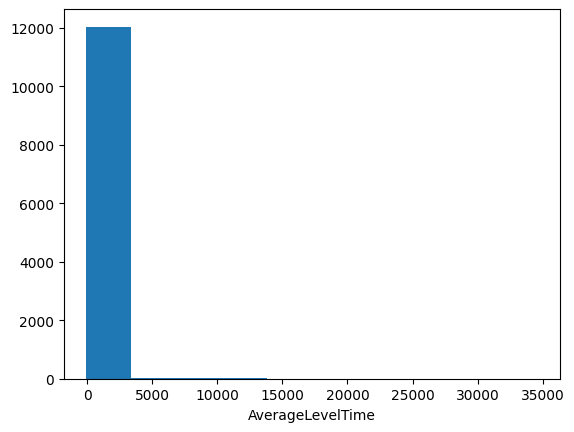

In [ ]:
f, ax = plt.subplots()
ax.hist(plot_data)
ax.set_xlabel(feature_to_visualize)

### Simple feature comparison scatterplot

In [ ]:
x_axis_feature = "AverageFails"
minimum_x_value = -math.inf
maximum_x_value = math.inf
y_axis_feature = "AverageLevelTime"
minimum_y_value = -math.inf
maximum_y_value = math.inf

range_filter = (df_session[x_axis_feature] > minimum_x_value) & (df_session[x_axis_feature] < maximum_x_value) \
             & (df_session[y_axis_feature] > minimum_y_value) & (df_session[y_axis_feature] < maximum_y_value)
scatter_data = df_session[[x_axis_feature, y_axis_feature]][range_filter]
print(scatter_data.describe())

       AverageFails  AverageLevelTime
count  10214.000000      10214.000000
mean       4.395034        122.963401
std        5.955671        863.582203
min        1.000000        -66.135500
25%        2.125000         19.306933
50%        3.000000         36.724239
75%        4.555556         65.492238
max      284.000000      34555.889000


Text(0, 0.5, 'AverageLevelTime')

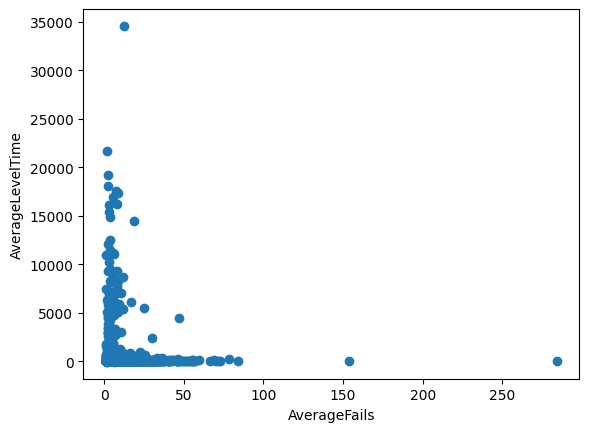

In [ ]:
f, ax = plt.subplots()
ax.scatter(scatter_data[x_axis_feature], scatter_data[y_axis_feature])
ax.set_xlabel(x_axis_feature)
ax.set_ylabel(y_axis_feature)

## How Many Players?

In [ ]:
# Not just "how many played at all", but "how many played and completed at least one level", or "played at least one minute."
level_completion_columns = df_session[df_session.columns[df_session.columns.str.endswith("Completed")]]

per_player_levels_completed = level_completion_columns.sum(axis=1)

In [ ]:
print(f"There were {df_session.shape[0]} sessions in the dataset (after cleaning).\nOf those, {per_player_levels_completed[per_player_levels_completed >= 1].shape[0]} sessions completed at least one level.")

There were 12099 sessions in the dataset (after cleaning).
Of those, 11507 sessions completed at least one level.


## How Far Did They Get?

Text(0.5, 1.0, 'Histogram for # of Different Levels Completed')

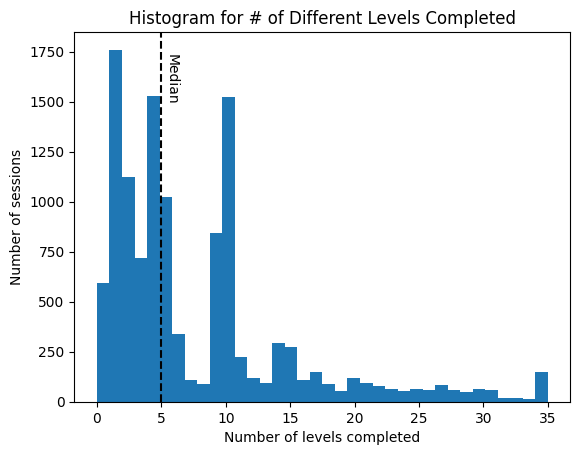

In [ ]:
f, ax = plt.subplots()
ax.hist(per_player_levels_completed, bins=36)
ax.axvline(x=per_player_levels_completed.median(), linestyle='--', color='k', label="Median")
ax.text(x=per_player_levels_completed.median() + 0.25, y=1500, s="Median", rotation=-90)
ax.set_xlabel("Number of levels completed")
ax.set_ylabel("Number of sessions")
ax.set_title("Histogram for # of Different Levels Completed")

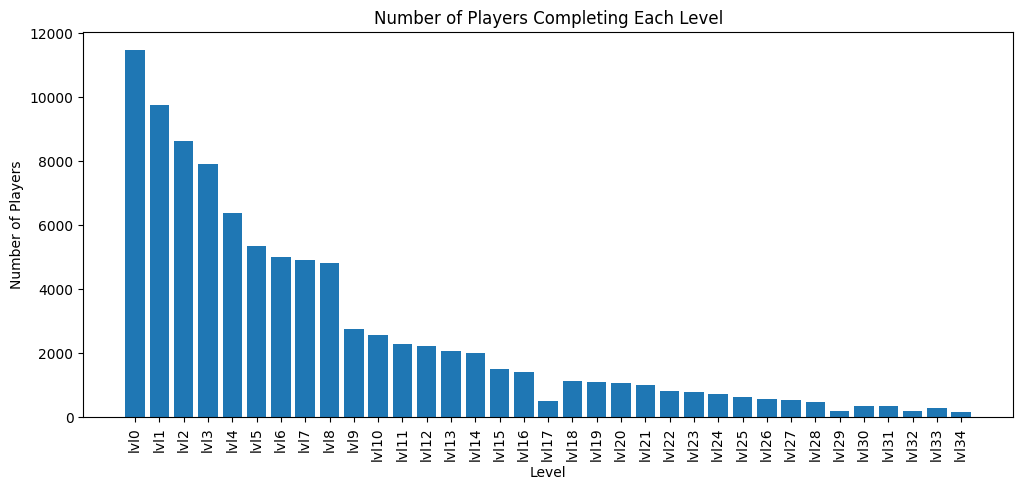

In [ ]:
per_level_completions = level_completion_columns.sum(axis=0)
f,ax = plt.subplots(figsize=(12, 5))
ax.bar([col.split('_')[0] for col in level_completion_columns.columns], per_level_completions)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel("Level")
ax.set_ylabel("Number of Players")
ax.set_title("Number of Players Completing Each Level")

## How Long Did They Play?

In [ ]:
time_feature = "AverageLevelTime"
df_session[time_feature].describe()

count    12099.000000
mean       105.725985
std        794.665767
min        -66.135500
25%         12.879889
50%         30.919700
75%         58.941682
max      34555.889000
Name: AverageLevelTime, dtype: float64

In [ ]:
minimum_value = 0
maximum_value = 1000

range_filter = (df_session[time_feature] > minimum_value) & (df_session[time_feature] < maximum_value)
time_data = df_session[time_feature][range_filter]
time_data.describe()

count    11380.000000
mean        50.337773
std         70.517608
min          0.736000
25%         14.934000
50%         32.515750
75%         59.652925
max        963.014556
Name: AverageLevelTime, dtype: float64

Text(0.5, 1.0, 'Histogram for Average Time Per Level')

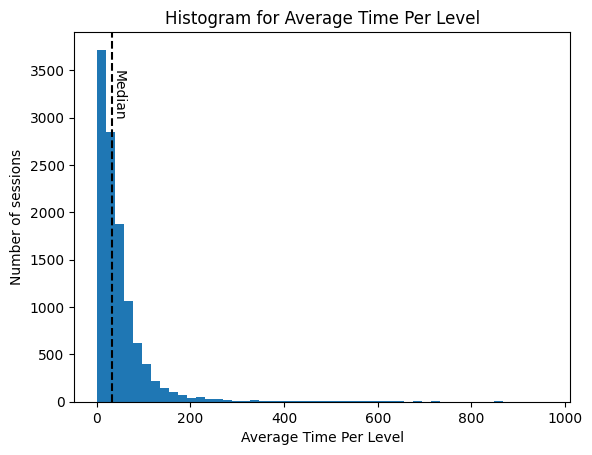

In [ ]:
f, ax = plt.subplots()
ax.hist(time_data, bins=50)
ax.axvline(x=time_data.median(), linestyle='--', color='k', label="Median")
ax.text(x=time_data.median() + 0.25, y=3000, s="Median", rotation=-90)
ax.set_xlabel("Average Time Per Level")
ax.set_ylabel("Number of sessions")
ax.set_title("Histogram for Average Time Per Level")

In [ ]:
level_time_columns = df_session[df_session.columns[df_session.columns.str.endswith("TotalLevelTime")]]

per_player_total_time = level_time_columns.sum(axis=1)
per_player_total_time.describe()

count     12099.000000
mean       1183.262604
std        9543.908709
min        -249.544000
25%          42.459500
50%         219.347000
75%         656.041500
max      489750.058000
dtype: float64

In [ ]:
minimum_value = 0
maximum_value = 5000

range_filter = (per_player_total_time > minimum_value) & (per_player_total_time < maximum_value)
total_time_data = per_player_total_time[range_filter]
total_time_data.describe()

count    11278.000000
mean       476.923657
std        648.393231
min          1.289000
25%         54.458000
50%        237.053500
75%        652.023750
max       4982.467000
dtype: float64

Text(0.5, 1.0, 'Histogram for Total Play Times')

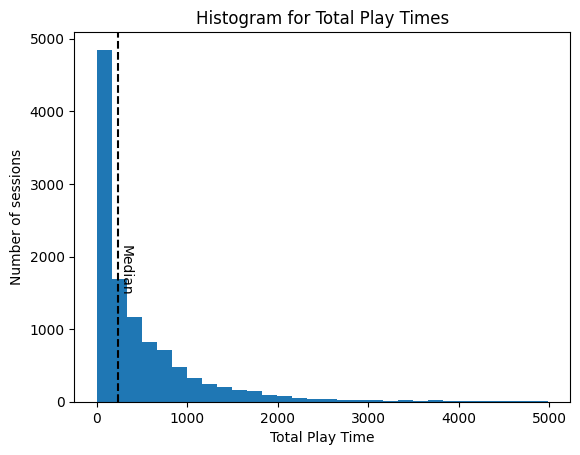

In [ ]:
f, ax = plt.subplots()
ax.hist(total_time_data, bins=30)
ax.axvline(x=total_time_data.median(), linestyle='--', color='k', label="Median")
ax.text(x=total_time_data.median() + 0.25, y=1500, s="Median", rotation=-90)
ax.set_xlabel("Total Play Time")
ax.set_ylabel("Number of sessions")
ax.set_title("Histogram for Total Play Times")

Text(0.5, 1.0, 'Total Time Played in each Level')

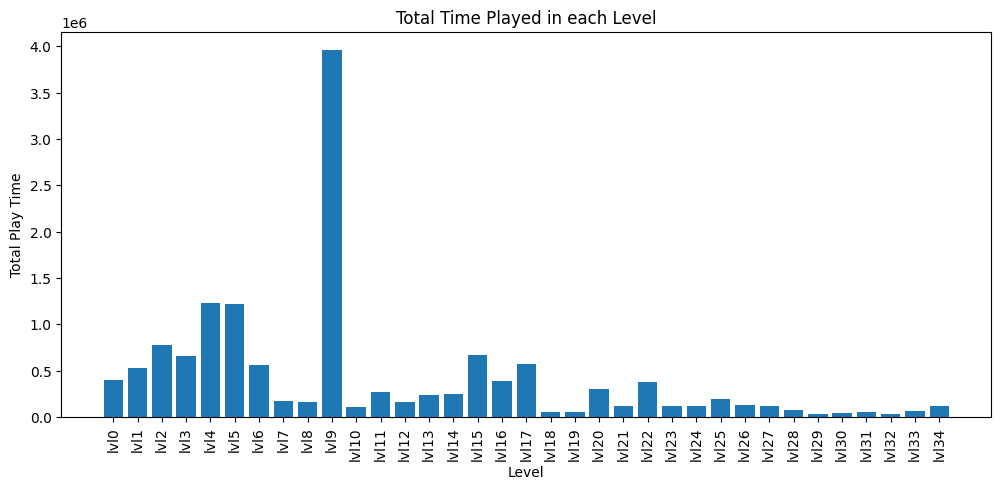

In [ ]:
per_level_total_time = level_time_columns.sum(axis=0)

f,ax = plt.subplots(figsize=(12, 5))
ax.bar([col.split('_')[0] for col in level_completion_columns.columns], per_level_total_time)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel("Level")
ax.set_ylabel("Total Play Time")
ax.set_title("Total Time Played in each Level")

next question: what do we want for the tests/visualizations/research?
do we need to step further into our feature systems

# Pairwise test

In [ ]:
#@markdown Choose your own metric for test here
response_variable = "AverageFails"
min_response_val = 0
max_response_val = 20
independent_variable = "AverageMoveTypeChanges" #@param {type:'string'}
min_independent_val = 0
max_independent_val = 6
# Dividing_value = "20" #@param {type: 'string'}
comparison_data = df_session[[response_variable, independent_variable]]
comparison_data = comparison_data[(df_session[response_variable] >= min_response_val) & (df_session[response_variable] <= max_response_val)
                                & (df_session[independent_variable] >= min_independent_val) & (df_session[independent_variable] <= max_independent_val)]
response_data = np.log(comparison_data[response_variable])
independent_data = comparison_data[independent_variable]

Text(0.5, 1.0, 'Histogram for AverageMoveTypeChanges')

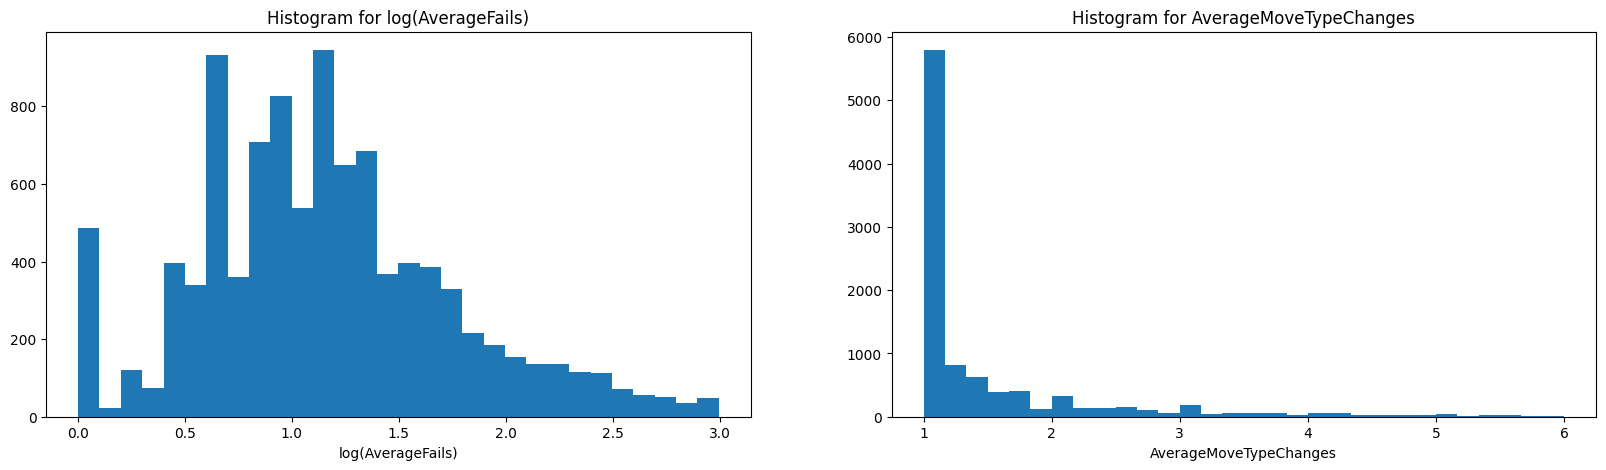

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax[0].hist(response_data, bins=30)
ax[0].set_xlabel(f"log({response_variable})")
ax[0].set_title(f"Histogram for log({response_variable})")
ax[1].hist(independent_data, bins=30)
ax[1].set_xlabel(independent_variable)
ax[1].set_title(f"Histogram for {independent_variable}")

In [ ]:
group_data = independent_data.ge(independent_data.mean())
group_data.describe()
# independent_data.describe()

count      9874
unique        2
top       False
freq       7225
Name: AverageMoveTypeChanges, dtype: object

In [ ]:
pairwise = pairwise_tukeyhsd(endog=response_data, groups=group_data, alpha=0.05)
print(pairwise)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 False   True   0.0109 0.4191 -0.0156 0.0374  False
---------------------------------------------------
